# Question 1:
### *Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?*

## Define Hypotheses

For this, we first need to define our hypotheses:
<br>
<br>
    ***Null Hypothesis:*** The presence of a discount has no effect on the quantity ordered.
<br>
    ***Alternate Hypothesis:*** The presence of a discount has a statistically significant effect on the quantity ordered. 

Perhaps the quickest way to answer the first half of our question (whether discounts affect quantity ordered) would be to use a **Welch's T-Test** (one-tailed) to compare the mean quantities ordered between two groups (discounts and no discounts).

We will be working with the dataset stored as `Northwind_small.sqlite`. For reference, the relational structure of this dataset is provided below.
<img src='Northwind_ERD.png'>

## Importing Libraries and Data

In [1]:
# For math & dataframes
import numpy as np
import pandas as pd

# For statistics
import scipy.stats as stats
from itertools import combinations
from scipy.special import comb

# For graphing
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")

# For SQL database work
import sqlite3

In [2]:
conn = sqlite3.connect('Northwind_small.sqlite')
c = conn.cursor()

c.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(c.fetchall())

[('Employee',), ('Category',), ('Customer',), ('Shipper',), ('Supplier',), ('Order',), ('Product',), ('OrderDetail',), ('CustomerCustomerDemo',), ('CustomerDemographic',), ('Region',), ('Territory',), ('EmployeeTerritory',)]


## Examine the relevant data

Let's look at the `OrderDetail` table.

In [3]:
c.execute("select * from 'OrderDetail';")
orderdetail_df = pd.DataFrame(c.fetchall())
orderdetail_df.columns = [x[0] for x in c.description]
display(orderdetail_df.head())
print('orderdetail_df\n',orderdetail_df.info())

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 6 columns):
Id           2155 non-null object
OrderId      2155 non-null int64
ProductId    2155 non-null int64
UnitPrice    2155 non-null float64
Quantity     2155 non-null int64
Discount     2155 non-null float64
dtypes: float64(2), int64(3), object(1)
memory usage: 101.1+ KB
orderdetail_df
 None


## Define functions we might need

Now, we need to define the functions we'll need to run a Welch's t-test.

In [4]:
def welch_t(a, b):
    """ Calculate Welch's t statistic for two samples. """
    numerator = a.mean() - b.mean()
    denominator = np.sqrt(a.var(ddof=1)/len(a) + b.var(ddof=1)/b.size)
    return abs(numerator/denominator)


def welch_df(a, b):
    """ Calculate the effective degrees of freedom for two samples. """
    num = (a.var(ddof=1)/a.size + b.var(ddof=1)/b.size)**2
    denom = ((a.var(ddof=1)**2) / (((a.size)**2) * (a.size-1))) + ((b.var(ddof=1)**2) / (((b.size)**2) * (b.size-1)))
    return num/denom


def p_value(a, b, two_sided=False):
    """
    Returns the p-value from a Welch's t-test given two datasets (lists, arrays, or series).
    """
    t = welch_t(a,b)
    df = welch_df(a,b)
    p = 1 - stats.t.cdf(t, df)
    if two_sided:
        p += p
    return p

## Start conducting tests

In [5]:
# Create two sample groups, A and B, of quantities ordered
a = orderdetail_df.loc[orderdetail_df.Discount == 0, ['Quantity']].Quantity
b = orderdetail_df.loc[orderdetail_df.Discount != 0, ['Quantity']].Quantity

In [6]:
# look at the percentile breakdown of both samples to determine where to cut off outliers
for q in np.linspace(.9, 1, num=11):
    aq =  round(a.quantile(q=q), 2)
    bq =  round(b.quantile(q=q), 2)
    print('{}th percentile:\tset1: {}\tset2: {}'.format(round(q,2), aq, bq))

0.9th percentile:	set1: 42.0	set2: 55.0
0.91th percentile:	set1: 45.0	set2: 60.0
0.92th percentile:	set1: 50.0	set2: 60.0
0.93th percentile:	set1: 50.0	set2: 60.0
0.94th percentile:	set1: 50.0	set2: 65.0
0.95th percentile:	set1: 55.0	set2: 70.0
0.96th percentile:	set1: 60.0	set2: 70.0
0.97th percentile:	set1: 60.0	set2: 80.0
0.98th percentile:	set1: 70.0	set2: 81.04
0.99th percentile:	set1: 80.0	set2: 100.0
1.0th percentile:	set1: 130.0	set2: 130.0


In [7]:
# Remove outliers (everything beyond 95th percentile)
a1 = orderdetail_df.loc[(orderdetail_df.Discount == 0) & (orderdetail_df.Quantity<=55), ['Quantity']].Quantity
b1 = orderdetail_df.loc[(orderdetail_df.Discount != 0) & (orderdetail_df.Quantity<=70), ['Quantity']].Quantity

Median Quantity Ordered: 	No Discount: 16.0 	Discount: 20.0
Mean Quantity Ordered: 		No Discount: 19.03 	Discount: 24.72
Sample sizes: 			No Discount: 1252 	Discount: 809
Welch's t-test p-value:		 0.0


C:\Users\Matthew Parker\.conda\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


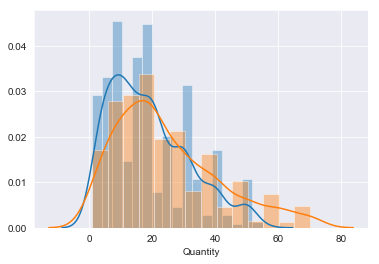

In [8]:
# Plot the distributions
sns.distplot(a1)
sns.distplot(b1);

# Calculate basic statistics and run Welch's t-test on samples
print(f"Median Quantity Ordered: \tNo Discount: {round(a1.median(),2)} \tDiscount: {round(b1.median(),2)}")
print(f"Mean Quantity Ordered: \t\tNo Discount: {round(a1.mean(),2)} \tDiscount: {round(b1.mean(),2)}")
print(f'Sample sizes: \t\t\tNo Discount: {len(a1)} \tDiscount: {len(b1)}')
print("Welch's t-test p-value:\t\t", p_value(a1, b1))

### Analysis

Looking at the sample statistics above, it looks like the presence of a product price discount typically increases the quantity ordered by approximately 5.7 units. Because the p-value from our Welch's t-test is 0.0, we know that there is virtually no chance that the null hypothesis (that discounts do not affect quantities ordered) is true. 

## What about level of discount?

Let's try running this process again, but this time selecting different levels of discount.

In [9]:
# First, discover what the distribution of discount percentages are
orderdetail_df.Discount.value_counts()

0.00    1317
0.05     185
0.10     173
0.20     161
0.15     157
0.25     154
0.03       3
0.02       2
0.01       1
0.04       1
0.06       1
Name: Discount, dtype: int64

Median Quantity Ordered: 	Control: 16.0 		0.01 Discount or more: 20.0
Mean Quantity Ordered: 		Control: 19.03 		0.01 Discount or more: 24.72
Sample sizes: 			Control: 1252 		0.01 Discount or more: 809
Welch's t-test p-value:		 0.0 
 
Median Quantity Ordered: 	Control: 16.0 		0.05 Discount or more: 20.0
Mean Quantity Ordered: 		Control: 19.03 		0.05 Discount or more: 24.92
Sample sizes: 			Control: 1252 		0.05 Discount or more: 802
Welch's t-test p-value:		 0.0 
 
Median Quantity Ordered: 	Control: 16.0 		0.1 Discount or more: 20.0
Mean Quantity Ordered: 		Control: 19.03 		0.1 Discount or more: 24.92
Sample sizes: 			Control: 1252 		0.1 Discount or more: 624
Welch's t-test p-value:		 1.9984014443252818e-15 
 
Median Quantity Ordered: 	Control: 16.0 		0.15 Discount or more: 21.0
Mean Quantity Ordered: 		Control: 19.03 		0.15 Discount or more: 25.79
Sample sizes: 			Control: 1252 		0.15 Discount or more: 457
Welch's t-test p-value:		 2.9976021664879227e-15 
 
Median Quantity Ordered: 	Con

C:\Users\Matthew Parker\.conda\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


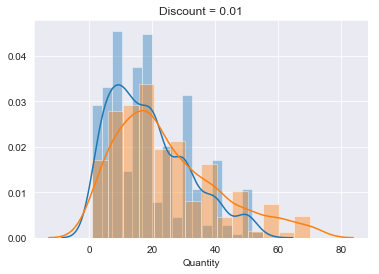

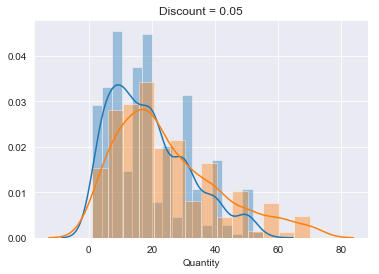

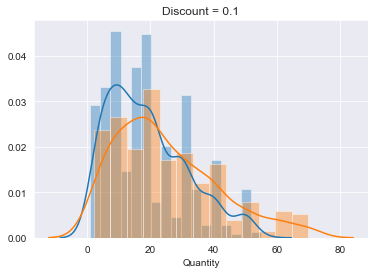

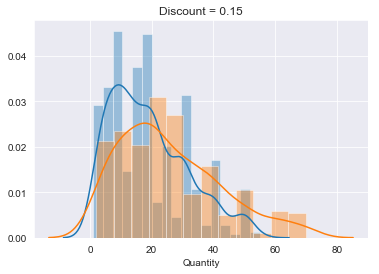

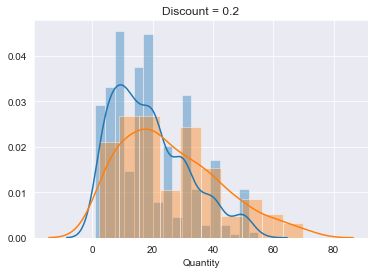

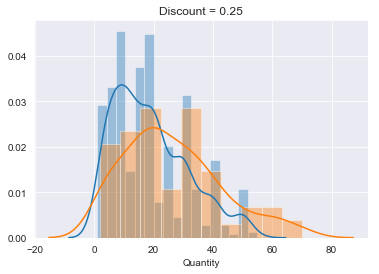

In [10]:
# Based on the above information, let's try iterations grouped 
# by every 5% change in discount.
for percent in [0.01, 0.05, 0.10, 0.15, 0.20, 0.25]:
    a1 = orderdetail_df.loc[(orderdetail_df.Discount == 0) & 
                            (orderdetail_df.Quantity<=55), ['Quantity']].Quantity
    b1 = orderdetail_df.loc[(orderdetail_df.Discount >= percent) & 
                            (orderdetail_df.Quantity<=70), ['Quantity']].Quantity
    print(f"Median Quantity Ordered: \tControl: {round(a1.median(),2)} \t\t{percent} Discount or more: {round(b1.median(),2)}")
    print(f"Mean Quantity Ordered: \t\tControl: {round(a1.mean(),2)} \t\t{percent} Discount or more: {round(b1.mean(),2)}")
    print(f'Sample sizes: \t\t\tControl: {len(a1)} \t\t{percent} Discount or more: {len(b1)}')
    print("Welch's t-test p-value:\t\t", p_value(a1, b1), "\n ")
    plt.figure()
    sns.distplot(a1)
    sns.distplot(b1)
    plt.title(f'Discount = {percent}');

### Analysis

As you can see, we have run several scenarios comparing the control (no discounts) group to sample groups generated by using various lower bound thresholds of discount value. Surprisingly, it seems that the size of the discount itself is almost irrelevant so long as a discount exists at all. 

A bit more specifically, discounts ranging from 1-10% generally increase the quantity ordered by 6 units, while discounts ranging from 15-25% increase the quantity ordered by 7 units. For all thresholds, the null hypothesis can be rejected with 99.999% confidence or more.